<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Assignment_8_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning programming task

**Assignment 8:** Autoencoders

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Aditya Dey : 230580 : aditya.dey@st.ovgu.de
3. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

**Experiments**

1. **Simple MLP Based Autoencoders**

a) Activations: Sigmoid, ReLU, Tanh

b) Loss Functions used: Mean squared error
2. **Convolutional Autoencoders**

a) Use any number of filters and layers, While decoding last layer must have same filters as input image. Conv2DTranspose is the layer at decoder.

b) With Upsampling at decoder.

c) With FC layer at encoder.

3. **Model interpretation (Used MNSIT for interpretability)**

a) Display filters

b) Changing the encoder states manually and output the image. Analyze it.


4. **Unsupervised Pretraining**

a) Train autoencoder – freeze encoder – train classifier on top (as described above).

b) Train autoencoder – train classifier on top of encoder. Do not freeze the encoder, i.e. the encoder is “fine-tuned” on the labeled subset of data as well.

c) Train a classifier directly on the labeled subset; no pretraining. For fairness, it should have the same architecture as the encoder + classifier above.




In [0]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np
import random

In [4]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import initializers
from datasets import MNISTDataset

Using TensorFlow backend.


In [0]:
files.upload()

Saving datasets.py to datasets.py


{'datasets.py': b'import numpy as np\n\n\nclass MNISTDataset:\n    """\'Bare minimum\' class to wrap MNIST numpy arrays into a dataset."""\n    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,\n                 to01=True, shuffle=True, seed=None):\n        """\n        Use seed optionally to always get the same shuffling (-> reproducible\n        results).\n        """\n        self.batch_size = batch_size\n        self.train_data = train_imgs\n        self.train_labels = train_lbs.astype(np.int32)\n        self.test_data = test_imgs\n        self.test_labels = test_lbls.astype(np.int32)\n\n        if to01:\n            # int in [0, 255] -> float in [0, 1]\n            self.train_data = self.train_data.astype(np.float32) / 255\n            self.test_data = self.test_data.astype(np.float32) / 255\n\n        self.size = self.train_data.shape[0]\n\n        if seed:\n            np.random.seed(seed)\n        if shuffle:\n            self.shuffle_train()\n        

In [5]:
  print(os.getcwd())
  print(tf.__version__)

/content
2.2.0


In [0]:
drive.mount('/content/drive')

In [6]:

path = '.'
 
files = os.listdir(path)
for name in files:
    print(name)

.config
datasets.py
conv_model_with_fc_noise.zip
__pycache__
sample_data


# **Data Preprocessing**

11493376/11490434 [==============================] - 0s 0us/step
[0 4 1 9 2 1 3 1 4]


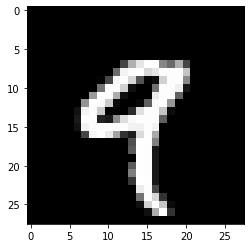

In [7]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[4], cmap="Greys_r")
print(train_labels[1:10])

#Normalizing images
train_images = train_images / 255.0

test_images = test_images / 255.0

In [8]:
flattened_data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
print(train_images.reshape([-1, 784]).shape)
train_images_flattened = train_images.reshape([-1, 784])
test_images_flattened = test_images.reshape([-1, 784])

(60000, 784)


In [9]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# **Simple MLP Autoencoders**

1) Using Mean squared error/MAE with relu, tanh and sigmoid

**Summary:**

1) Most of the models created did not have any sort of regularization, denoising to prevent network to copying the input to output rather than learning. Even with this models that had sigmoid or tanh in hidden layers did not learn anything (even copying). Instead they cheated by trying to decrease the loss by simply outputing white pixel cluster near centers and block at edges. model_tanh, model_sigmoids output can be seen here as an example.

2) Model with relu at hidden and sigmoid at output gave relatively better performance than others, as it learnt to predict/or atleast copy input to output

3) Model with relu as hidden and linear at the output gave blurred versions of the images and they were not as clear as with sigmoid at output. This could be because linear at output could have negative values or any other values that don't scale/fit well when converted to pixel values, whilst sigmoids output is between 0/1 makes it better for output layer in this case.

4) Same with Model with sigmoid as hidden and linear as out. The images were blurred but also some wrong predictions. For example it was matching anything with stright stroke to 7(1->7, 7-> 7), similary 3 to 8

In [0]:
def create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="sigmoid",hidden_activation="relu"):
  model = keras.Sequential([keras.layers.Flatten(input_shape=input_shape)])
  #Loop till penultimate layer that is the penultimate decoder
  for i in range (len(layer_dims)-1):
    model.add(tf.keras.layers.Dense(units=layer_dims[i],activation=hidden_activation))
  
  #Add the output at end
  model.add(tf.keras.layers.Dense(units=layer_dims[-1],activation=output_activation)) 
  return model;



In [0]:
model_relu = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="sigmoid",hidden_activation="relu")
model_sigmoid = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="sigmoid",hidden_activation="sigmoid")
model_tanh = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="sigmoid",hidden_activation="tanh")
model_linear = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="sigmoid",hidden_activation="linear")


In [0]:
model_linear2 = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="linear",hidden_activation="sigmoid")

In [0]:
model_linear3 = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="linear",hidden_activation="relu")

In [0]:
model_relu2 = create_mlp_model(input_shape=(28, 28), layer_dims=[256,128,64,32,64,128,256,784],output_activation="sigmoid",hidden_activation="relu")


In [0]:
#Printing model summary to initial check
model_relu.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_80 (Dense)             (None, 128)             

In [0]:
def compile_mlp_model(model,loss="MAE", metrics=["accuracy"], optimizer = "adam"):
  if(loss == "MAE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MAE, metrics=metrics)
  elif (loss == "MSQE"):
    model.compile(optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=metrics)
  else:
    model.compile(optimizer=optimizer, loss=tf.keras.losses.binary_crossentropy, metrics=metrics)


In [0]:

compile_mlp_model(model_linear, loss = "MSQE", metrics=["accuracy", tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])
compile_mlp_model(model_tanh, loss = "MSQE", metrics=["accuracy", tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])
compile_mlp_model(model_sigmoid, loss = "MSQE", metrics=["accuracy", tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])
compile_mlp_model(model_relu, loss = "MSQE", metrics=["accuracy", tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])


In [0]:
compile_mlp_model(model_linear2, loss = "MSQE", metrics=["accuracy"])

In [0]:
compile_mlp_model(model_linear2, loss = "MSQE", metrics=["accuracy"])

In [0]:
compile_mlp_model(model_linear3, loss = "MSQE", metrics=["accuracy"])

In [0]:
compile_mlp_model(model_sigmoid, loss = "MSQE", metrics=["accuracy", tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

In [0]:
compile_mlp_model(model_relu2, metrics=["accuracy"])

In [0]:
model_linear2.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_116 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_117 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_118 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_119 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_120 (Dense)            (None, 128)             

In [0]:
model_relu2.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2768 - accuracy: 0.0148
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2867 - accuracy: 0.0140
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2887 - accuracy: 0.0139
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2864 - accuracy: 0.0145
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2914 - accuracy: 0.0120
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2915 - accuracy: 0.0121
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 33.2915 - accuracy: 0.0121
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2915 - accuracy: 0.0121
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 33.2915 - accuracy: 0.0121
Epoch 10/10
1875/1875 [==============================] - 11s 6ms

In [0]:
model_linear3.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 1702.9707 - accuracy: 0.0105
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 1137.7051 - accuracy: 0.0115
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 1016.9025 - accuracy: 0.0133
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 952.8574 - accuracy: 0.0125
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 909.0300 - accuracy: 0.0131
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 879.6067 - accuracy: 0.0127
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 855.2213 - accuracy: 0.0121
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 837.8210 - accuracy: 0.0124
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 821.3605 - accuracy: 0.0127
Epoch 10/10
1875/1875 [=============================

In [0]:
model_linear2.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 4604.4775 - accuracy: 0.0137
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 4374.1289 - accuracy: 0.0146
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 4350.4541 - accuracy: 0.0127
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 4157.1177 - accuracy: 0.0116
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 3947.8176 - accuracy: 0.0113
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 3832.3359 - accuracy: 0.0114
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 3754.3936 - accuracy: 0.0116
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 3697.3875 - accuracy: 0.0123
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 3639.0488 - accuracy: 0.0146
Epoch 10/10
1875/1875 [=======================

In [0]:
model_linear.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7221.9443 - accuracy: 0.0000e+00 - false_negatives: 794109.0000 - false_positives: 13219973.0000
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7221.9478 - accuracy: 0.0000e+00 - false_negatives: 794109.0000 - false_positives: 13219973.0000
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7221.9409 - accuracy: 0.0000e+00 - false_negatives: 794109.0000 - false_positives: 13219971.0000
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7221.9443 - accuracy: 0.0000e+00 - false_negatives: 794112.0000 - false_positives: 13219956.0000
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7222.0732 - accuracy: 0.0000e+00 - false_negatives: 813141.0000 - false_positives: 13184653.0000
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7222.2314 - accuracy: 0.0000e+00 - false_negatives: 8

In [0]:
model_relu.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0309 - accuracy: 0.0103 - false_negatives_3: 3736640.0000 - false_positives_3: 453538.0000
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0173 - accuracy: 0.0105 - false_negatives_3: 3030544.0000 - false_positives_3: 180712.0000
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0143 - accuracy: 0.0100 - false_negatives_3: 2931204.0000 - false_positives_3: 128835.0000
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0126 - accuracy: 0.0114 - false_negatives_3: 2878755.0000 - false_positives_3: 101436.0000
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0114 - accuracy: 0.0123 - false_negatives_3: 2848355.0000 - false_positives_3: 83874.0000
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0106 - accuracy: 0.0131 - false_negatives_3: 2830101.0000 - false_positi

In [0]:
model_sigmoid.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.2334 - accuracy: 0.0026 - false_negatives_2: 18343.0000 - false_positives_2: 22896954.0000
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0522 - accuracy: 0.0032 - false_negatives_2: 10986.0000 - false_positives_2: 23037136.0000
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0483 - accuracy: 0.0032 - false_negatives_2: 10748.0000 - false_positives_2: 23054412.0000
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0522 - accuracy: 0.0031 - false_negatives_2: 11118.0000 - false_positives_2: 22959520.0000
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0483 - accuracy: 0.0029 - false_negatives_2: 11061.0000 - false_positives_2: 22926828.0000
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0527 - accuracy: 0.0026 - false_negatives_2: 11475.00

In [0]:
model_tanh.fit(train_images, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.2412 - accuracy: 9.3333e-04 - false_negatives_1: 19685.0000 - false_positives_1: 22893664.0000
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0596 - accuracy: 0.0019 - false_negatives_1: 10933.0000 - false_positives_1: 23016404.0000
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0474 - accuracy: 0.0032 - false_negatives_1: 10644.0000 - false_positives_1: 23035794.0000
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0308 - accuracy: 0.0021 - false_negatives_1: 10113.0000 - false_positives_1: 22167686.0000
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7217.0137 - accuracy: 0.0018 - false_negatives_1: 9544.0000 - false_positives_1: 21443900.0000
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 7216.9995 - accuracy: 0.0049 - false_negatives_1: 9934.

In [0]:
def evaluate_and_output_model(model, test_labels, test_images, reshape_matrix = [-1, 784], image_matrix=[10000,28,28], images_to_be_compared=5):
  class_names = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9']
  print(test_images.shape)
  #test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
  print(test_images.shape)
  #print('\n  Relu Test accuracy:', str(test_acc) + " test loss: " + str(test_loss) + "\n")
  test_output_model = model.predict(test_images)
  model_output_images = test_output_model.reshape(image_matrix)
  print(model_output_images.shape)
  plt.figure(figsize=(10,10))
  j = -1
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = j+1
      if(i%2 == 0):
        plt.imshow(test_images[i+10], cmap=plt.cm.binary)
      elif(j%2 == 1):
        
        plt.imshow(model_output_images[j-1+10], cmap="Greys_r")
      
      #plt.xlabel(class_names[test_images[i]])
  plt.show()


"""
test_loss, test_acc = model.evaluate(test_images.reshape([-1, 784]),  test_labels, verbose=2)
test_output_model = model.predict(test_images.reshape([-1, 784]),)
model_output_images = test_output_model.reshape([10000,28,28])
plt.imshow(model2_output_images[7], cmap="Greys_r")
"""

'\ntest_loss, test_acc = model.evaluate(test_images.reshape([-1, 784]),  test_labels, verbose=2)\ntest_output_model = model.predict(test_images.reshape([-1, 784]),)\nmodel_output_images = test_output_model.reshape([10000,28,28])\nplt.imshow(model2_output_images[7], cmap="Greys_r")\n'

(10000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


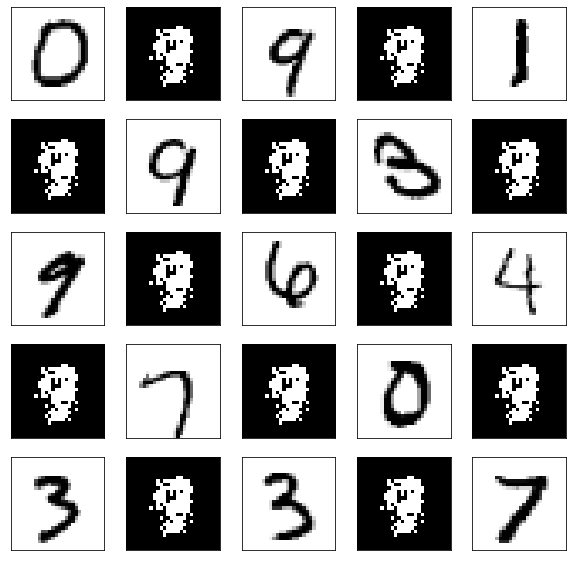

In [0]:
evaluate_and_output_model(model_relu2, test_labels, test_images)

(10000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


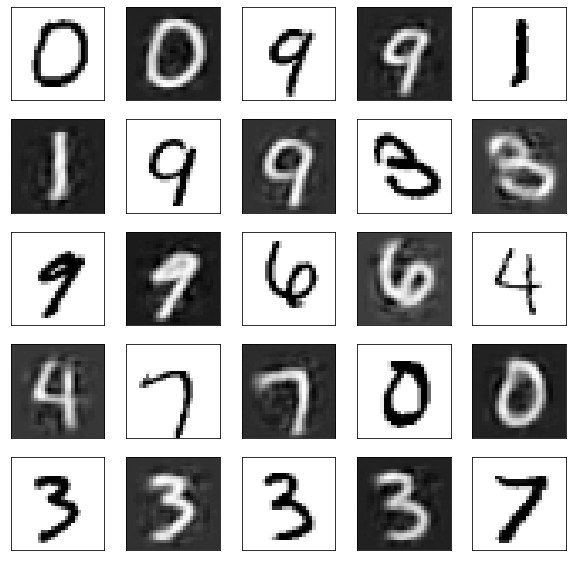

In [0]:
evaluate_and_output_model(model_linear3, test_labels, test_images)

(10000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


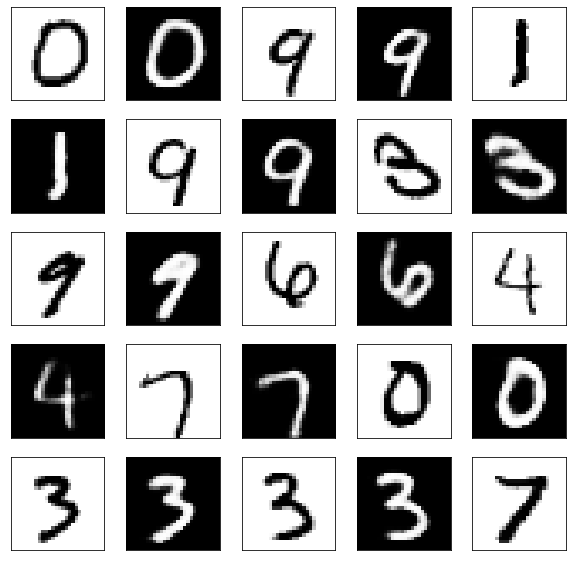

In [0]:
evaluate_and_output_model(model_relu, test_labels, test_images)

(10000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


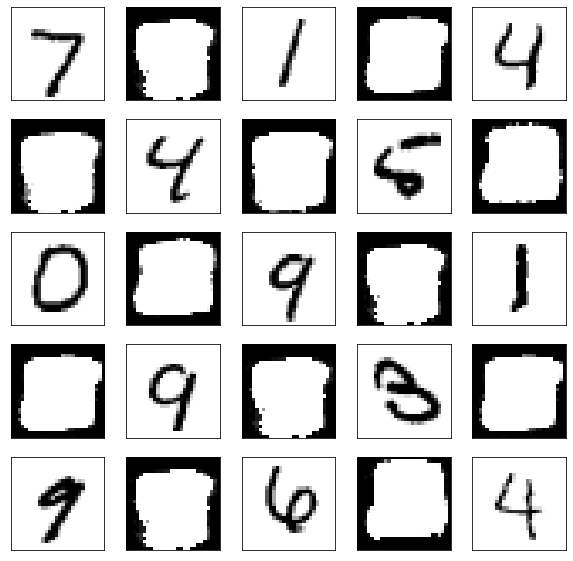

In [0]:
evaluate_and_output_model(model_tanh, test_labels, test_images)

(10000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


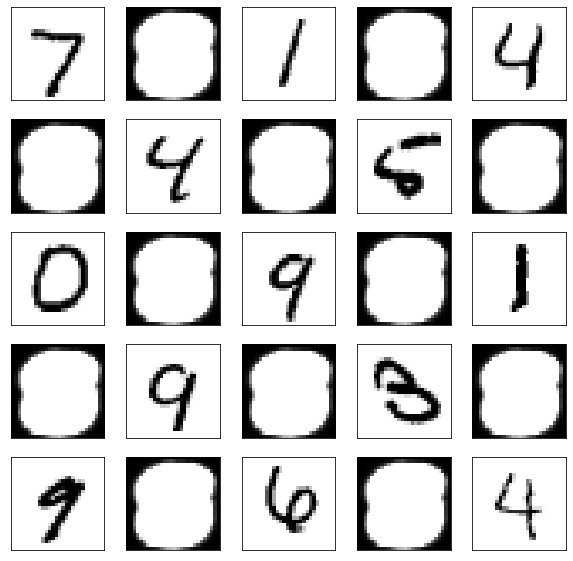

In [0]:
evaluate_and_output_model(model_sigmoid, test_labels, test_images)

(10000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


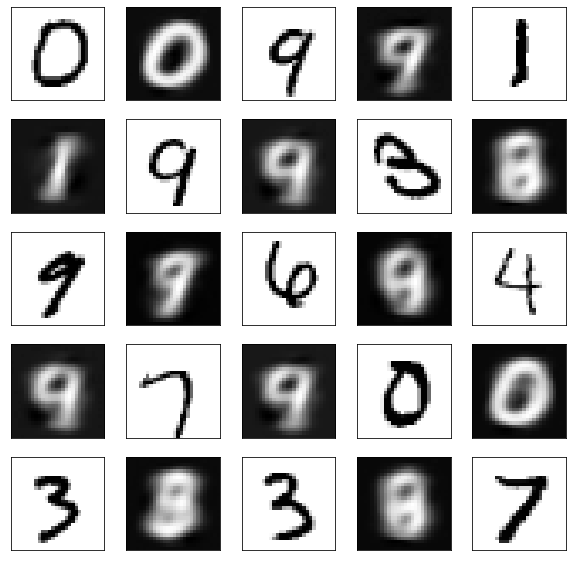

In [0]:
evaluate_and_output_model(model_linear2, test_labels, test_images)

In [0]:
model_relu.save(filepath="/content/model_relu")
model_tanh.save(filepath="/content/model_tanh")
model_sigmoid.save(filepath="/content/model_sigmoid")
model_linear.save(filepath="/content/model_linear")

INFO:tensorflow:Assets written to: /content/model_relu/assets
INFO:tensorflow:Assets written to: /content/model_tanh/assets
INFO:tensorflow:Assets written to: /content/model_sigmoid/assets
INFO:tensorflow:Assets written to: /content/model_linear/assets


In [0]:
!zip -r /content/model_relu.zip /content/model_relu
!zip -r /content/model_tanh.zip /content/model_tanh
!zip -r /content/model_linear.zip /content/model_linear
!zip -r /content/model_sigmoid.zip /content/model_sigmoid

  adding: content/model_relu/ (stored 0%)
  adding: content/model_relu/assets/ (stored 0%)
  adding: content/model_relu/variables/ (stored 0%)
  adding: content/model_relu/variables/variables.index (deflated 69%)
  adding: content/model_relu/variables/variables.data-00000-of-00001 (deflated 32%)
  adding: content/model_relu/saved_model.pb (deflated 89%)
  adding: content/model_tanh/ (stored 0%)
  adding: content/model_tanh/assets/ (stored 0%)
  adding: content/model_tanh/variables/ (stored 0%)
  adding: content/model_tanh/variables/variables.index (deflated 69%)
  adding: content/model_tanh/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/model_tanh/saved_model.pb (deflated 90%)
  adding: content/model_linear/ (stored 0%)
  adding: content/model_linear/assets/ (stored 0%)
  adding: content/model_linear/variables/ (stored 0%)
  adding: content/model_linear/variables/variables.index (deflated 70%)
  adding: content/model_linear/variables/variables.data-00000-of-00

In [0]:
model2 = keras.Sequential([
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(256, activation="sigmoid"),
    keras.layers.Dense(784)
])

In [0]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.MAE, #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model2.fit(train_images_flattened, train_images_flattened,  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 32.2754 - accuracy: 0.0126
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.8131 - accuracy: 0.0150
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7963 - accuracy: 0.0149
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7965 - accuracy: 0.0149
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7962 - accuracy: 0.0148
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7962 - accuracy: 0.0150
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7963 - accuracy: 0.0149
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7964 - accuracy: 0.0152
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 31.7963 - accuracy: 0.0150
Epoch 10/10
1875/1875 [==============================] - 10s 5ms

In [0]:
test_loss, test_acc = model_linear.evaluate(test_images,  test_labels, verbose=2)

print('\n  Relu Test accuracy:', str(test_acc) + " test loss: " + str(test_loss) + "\n")

test_loss, test_acc = model_relu.evaluate(test_images,  test_images, verbose=2)

print('\n Sigmoid Test accuracy:', str(test_acc) + " test loss: " + str(test_loss))

In [0]:
test_output_model = model.predict(test_images.reshape([-1, 784]),)
test_output_model2 = model2.predict(test_images.reshape([-1, 784]),)

In [0]:
test_output_model2.shape
#(10000, 28, 28)

(10000, 784)

In [0]:
model2_output_images = test_output_model2.reshape([10000,28,28])
model_output_images = test_output_model.reshape([10000,28,28])

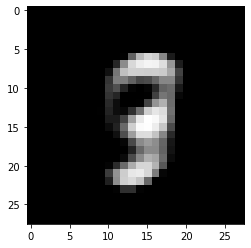

In [0]:
plt.imshow(model2_output_images[7], cmap="Greys_r")
#plt.imshow(test_images.reshape([-1, 784])[7], cmap="Greys_r")

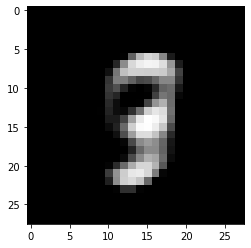

In [0]:
plt.imshow(model2_output_images[12], cmap="Greys_r")

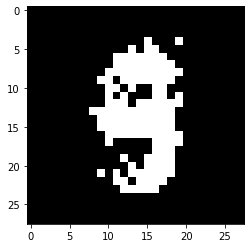

In [0]:
plt.imshow(model_output_images[7], cmap="Greys_r")

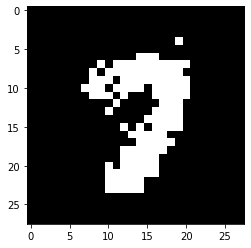

In [0]:
plt.imshow(model_output_images[0], cmap="Greys_r")

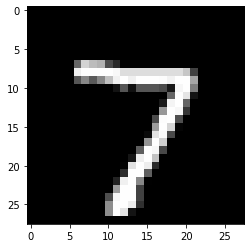

In [0]:
plt.imshow(test_images[0], cmap="Greys_r")

# **Convolutional Autoencoders**

**1) Normal Convolution and deconvolution:** Without batchnorm, this gives crap results as network gets the data easy. With batch norm we are forcing network to learn or atleast properly copy input to output, So we saw a bit better results with batchnorm and de convolution. Also the numbers 3,9 which had problems in upsampling or FC seems to be looking fine in this setup. Hence we decided to keep batchnorm for rest of the models as default

**2) Upscaling:** We can see some minute changes when we observer numbers 3 and 9. The 3 while upscaling has some extra black pixels at the tip of the number making 3 look like 8. Similary the white pixels in middle of number 9 seems to have vanished

**3) Fully connected at the middle:** We can see some minute changes when we observer numbers 9. The white pixels in middle of number 9 seems to have vanished. This may be due to compression/FC layer packing all info densely and maybe this white area was redundant info to classify number as 9.


**Errors:**  Since we did not model encoder/decoder seperately and stacked them together instead modelled encoder-decoder as part of same model, we faced some issues in decoder part as decoder output was 32 - 32 when it should be 28 - 28. We used valid padding in only first decoder layer and finally got the output dimension to 32*32. In future better way to code would be to stack separate encoder and decoder rather than putting them in same model.

In [0]:
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = mnist.load_data()

train_data = tf.data.Dataset.from_tensor_slices(( train_images_raw.astype(np.float32)/255.0, train_images_raw.astype(np.float32)/255.0 ))

train_data = train_data.shuffle(buffer_size = train_images_raw.shape[0]).batch(32)

#test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0, test_labels_raw.astype(np.int32) ))
test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0,  test_images_raw.astype(np.float32)/255.0 ))
test_data = test_data.batch(32)

In [0]:
input_shape = (train_images_raw.shape[1], train_images_raw.shape[2], 1)
print(input_shape)
print(train_images_raw.shape)

(28, 28, 1)
(60000, 28, 28)


In [0]:
"""
def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(filters = 32, kernel_size=(3, 3),  padding = "same", activation=tf.nn.relu,name = "conv_enc1", input_shape = input_shape))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), padding = "same", activation = tf.nn.relu, name = "conv_enc2"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters = 128, kernel_size=(3, 3),   padding = "same", activation = tf.nn.relu, name = "conv_enc3"))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(filters = 64, kernel_size=(1, 1),  padding = "same", activation = tf.nn.relu, name = "conv_compression_dim_reduce"))
  model.add(layers.Conv2DTranspose(filters = 32, kernel_size=(3, 3), strides=(2,2),  activation = tf.nn.relu, name = "conv_dec1"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(filters = 16, kernel_size=(3, 3), strides=(2,2),  padding = "same", activation = tf.nn.relu, name = "conv_dec2"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(filters = 1, kernel_size=(3, 3), strides=(2,2), padding = "same", activation = tf.nn.sigmoid, name = "conv_dec3"))
  print(model.summary())
  return model;

conv_model1 = create_model()
"""

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc1 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc2 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv_enc3 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv_compression_dim_reduce  (None, 3, 3, 64)         

In [0]:
def create_conv_autoencoder_model(encoder_layer_dims=[32,64,128], compression_layer_dim=64, decoder_layer_dims=[32, 16, 1], input_shape=(28,28,1), ks=3,
                 compression_flag=True ,batch_norm_flag=True, dense_latent_rep_flag=False, upsampling_flag = False):
  model = models.Sequential()
  
  #Build encoder part, add batch norm after encoder if batch norm flag is set to true
  conv_enc_base_name = "conv_enc_"
  conv_cmprsn_base_name = "conv_compress_dims"
  conv_dec_base_name = "conv_dec_"
  for i in range (len(encoder_layer_dims)):
    #For first layer we need to specify shape
    if(i == 0):
      model.add(layers.Conv2D(filters = encoder_layer_dims[i], kernel_size=(ks, ks),  padding = "same", 
                              activation=tf.nn.relu, name = conv_enc_base_name + str(i), input_shape = input_shape))
      if(batch_norm_flag):
        model.add(layers.BatchNormalization()) 

      model.add(layers.MaxPool2D(pool_size=(2,2)))
    else:
      model.add(layers.Conv2D(filters = encoder_layer_dims[i], kernel_size=(ks, ks),  padding = "same", 
                              activation=tf.nn.relu, name = conv_enc_base_name + str(i)))
      
      if(batch_norm_flag):
        model.add(layers.BatchNormalization()) 

      model.add(layers.MaxPool2D(pool_size=(2,2)))
  
  print("Encoder has been built, checking for compression flag")

  if(compression_flag):
    model.add(layers.Conv2D(filters = compression_layer_dim, kernel_size=(1, 1),  padding = "same", activation = tf.nn.relu, name = conv_cmprsn_base_name))

  # With one-d dense representation is hardcoded for this one casem without this we can pick dynamically
  if(dense_latent_rep_flag):
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation=tf.nn.relu))
    model.add(layers.Dense(64,activation=tf.nn.leaky_relu))
    model.add(layers.Dense(252,activation=tf.nn.relu))
    model.add(layers.Reshape((3, 3, 28), input_shape=(252,)))

  print("FC layer added, printing model summary")

  #print(model.summary())
  #Build Decoder , add batch norm before adding conv transpose, Use sigmoid at final layer and relu for others
  if(upsampling_flag == False):
    for i in range (len(decoder_layer_dims)):
      if(i == 0):
        if(batch_norm_flag):
          model.add(layers.BatchNormalization()) 

        model.add(layers.Conv2DTranspose(filters = decoder_layer_dims[i], kernel_size=(ks, ks),  strides=(2,2), padding = "valid", 
                                  activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
        
      elif(i < len(decoder_layer_dims)-1 and i > 0):

        if(batch_norm_flag):
          model.add(layers.BatchNormalization()) 

        model.add(layers.Conv2DTranspose(filters = decoder_layer_dims[i], kernel_size=(ks, ks),  strides=(2,2), padding = "same", 
                                  activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
      else:
        if(batch_norm_flag):
          model.add(layers.BatchNormalization())  

        model.add(layers.Conv2DTranspose(filters = decoder_layer_dims[i], kernel_size=(ks, ks), strides=(2,2), padding = "same", 
                                  activation=tf.nn.sigmoid, name = conv_dec_base_name + str(i)))
        
  elif(upsampling_flag == True):
      print("Upscaling with convolution choosen")
      for i in range (len(decoder_layer_dims)):
        if(i == 0):
          model.add(layers.UpSampling2D(size=(3, 3)))
          if(batch_norm_flag):
            model.add(layers.BatchNormalization()) 

          model.add(layers.Conv2D(filters = decoder_layer_dims[i], kernel_size=(ks, ks), padding = "valid", activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
          model.add(layers.UpSampling2D())

        elif(i < len(decoder_layer_dims)-1 and i > 0):

          if(batch_norm_flag):
            model.add(layers.BatchNormalization()) 

          model.add(layers.Conv2D(filters = decoder_layer_dims[i], kernel_size=(ks, ks), padding = "same", activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
          model.add(layers.UpSampling2D())
        else:
          if(batch_norm_flag):
            model.add(layers.BatchNormalization())  

          model.add(layers.Conv2D(filters = decoder_layer_dims[i], kernel_size=(ks, ks),  padding = "same", activation=tf.nn.sigmoid, name = conv_dec_base_name + str(i)))
        
  print("Model has been built, printing summary")
  
  print(model.summary())
  return model;

conv_model_with_upsampling = create_conv_autoencoder_model(upsampling_flag=True)

Encoder has been built, checking for compression flag
FC layer added, printing model summary
Upscaling with convolution choosen
Model has been built, printing summary
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_93 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_94 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_70 (

In [0]:
conv_model_with_upsampling.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_93 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_94 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 7, 7, 128)       

In [0]:
conv_model_with_fc = create_conv_autoencoder_model(dense_latent_rep_flag=True)
conv_model_with_fc.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_45 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 7, 7, 128)       

In [0]:
conv_model_with_batchnorm = create_conv_autoencoder_model()
conv_model_with_batchnorm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_23 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 7, 7, 128)       

In [0]:
conv_model_without_batchnorm = create_conv_autoencoder_model(batch_norm_flag=False)

Encoder has been built, checking for compression flag
Model has been built, printing summary
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 128)         0         
__________________________

In [0]:
conv_model_with_batchnorm.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["accuracy"])
conv_model_without_batchnorm.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["accuracy"])

In [0]:
conv_model_with_fc.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["accuracy"])

In [0]:
conv_model_with_upsampling.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["accuracy"])

In [0]:
x = tf.expand_dims(train_images_raw.astype(np.float32)/255.0 , -1)
y = tf.expand_dims(train_images_raw.astype(np.float32)/255.0, -1)
print(x.shape)
print(x.dtype)

(60000, 28, 28, 1)
<dtype: 'float32'>


In [0]:
conv_model_with_batchnorm.fit(x=x, y=y, epochs = 7)
conv_model_without_batchnorm.fit(x=x, y=y, epochs = 7)

Epoch 1/7
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0497 - accuracy: 0.8055
Epoch 2/7
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0179 - accuracy: 0.8153
Epoch 3/7
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0157 - accuracy: 0.8154
Epoch 4/7
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0147 - accuracy: 0.8154
Epoch 5/7
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0139 - accuracy: 0.8154
Epoch 6/7
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0133 - accuracy: 0.8154
Epoch 7/7
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0128 - accuracy: 0.8154
Epoch 1/7
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1338 - accuracy: 0.8074
Epoch 2/7
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1307 - accuracy: 0.8088
Epoch 3/7
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1307

In [0]:
conv_model_with_fc.fit(x=x, y=y, epochs=7)

Epoch 1/7
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0787 - accuracy: 0.7871
Epoch 2/7
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0303 - accuracy: 0.8138
Epoch 3/7
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0266 - accuracy: 0.8144
Epoch 4/7
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0247 - accuracy: 0.8147
Epoch 5/7
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0234 - accuracy: 0.8148
Epoch 6/7
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0224 - accuracy: 0.8149
Epoch 7/7
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0217 - accuracy: 0.8150


In [0]:
conv_model_with_upsampling.fit(x=x, y=y, epochs=7)

Epoch 1/7
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0476 - accuracy: 0.8051
Epoch 2/7
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0249 - accuracy: 0.8146
Epoch 3/7
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0218 - accuracy: 0.8150
Epoch 4/7
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0203 - accuracy: 0.8151
Epoch 5/7
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0192 - accuracy: 0.8152
Epoch 6/7
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0184 - accuracy: 0.8153
Epoch 7/7
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0178 - accuracy: 0.8153


In [0]:
def evaluate_and_output_model(model, test_images, images_to_be_compared=5):
  class_names = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9']
  print(test_images.shape)
  #test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
  print(test_images.shape)
  #print('\n  Relu Test accuracy:', str(test_acc) + " test loss: " + str(test_loss) + "\n")
  model_output_images = model.predict(test_images)
  print(model_output_images.shape)
  plt.figure(figsize=(10,10))
  j = -1
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = j+1
      if(i%2 == 0):
        plt.imshow(test_images[i+10][:,:,0], cmap=plt.cm.binary)
      elif(j%2 == 1):
        
        plt.imshow(model_output_images[j-1+10][:,:,0], cmap=plt.cm.binary)
      
      #plt.xlabel(class_names[test_images[i]])
  plt.show()

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


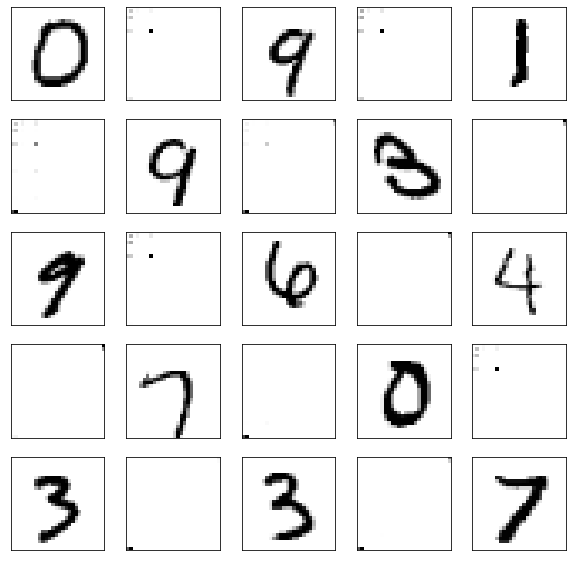

In [0]:
evaluate_and_output_model(conv_model_without_batchnorm, tf.expand_dims(test_images_raw.astype(np.float32)/255.0, -1))

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


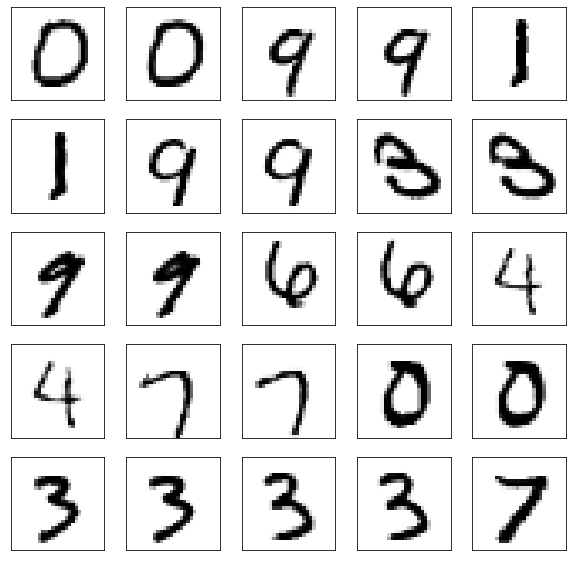

In [0]:
evaluate_and_output_model(conv_model_with_batchnorm, tf.expand_dims(test_images_raw.astype(np.float32)/255.0, -1))

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


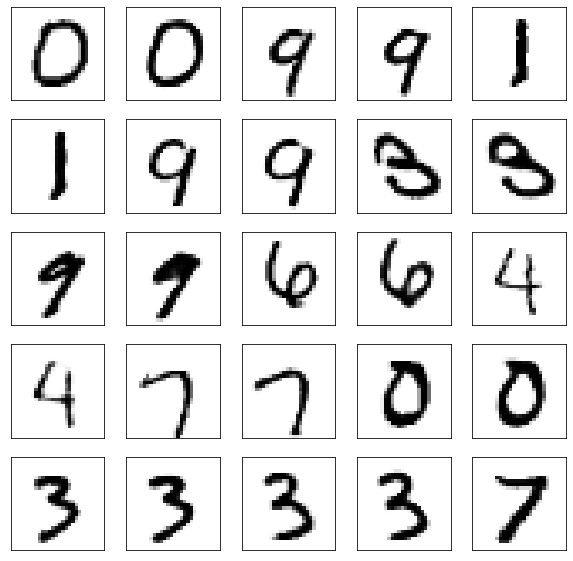

In [0]:
evaluate_and_output_model(conv_model_with_fc, tf.expand_dims(test_images_raw.astype(np.float32)/255.0, -1))

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


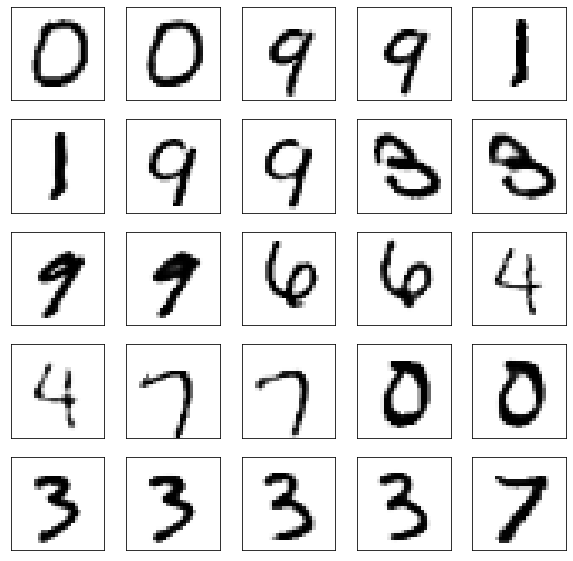

In [0]:
evaluate_and_output_model(conv_model_with_upsampling, tf.expand_dims(test_images_raw.astype(np.float32)/255.0, -1))

In [0]:
!mkdir "/content/conv_model_without_batchnorm"
!mkdir "/content/conv_model_with_batchnorm"
!mkdir "/content/conv_model_with_upsampling"
!mkdir "/content/conv_model_with_fc"

In [0]:
conv_model_without_batchnorm.save("/content/conv_model_without_batchnorm")
conv_model_with_batchnorm.save("/content/conv_model_with_batchnorm")
conv_model_with_upsampling.save("/content/conv_model_with_upsampling")
conv_model_with_fc.save("/content/conv_model_with_fc")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/conv_model_without_batchnorm/assets
INFO:tensorflow:Assets written to: /content/conv_model_with_batchnorm/assets
INFO:tensorflow:Assets written to: /content/conv_model_with_upsampling/assets
INFO:tensorflow:Assets written to: /content/conv_model_with_fc/assets


In [0]:
!zip -r /content/conv_model_without_batchnorm.zip /content/conv_model_without_batchnorm
!zip -r /content/conv_model_with_batchnorm.zip /content/conv_model_with_batchnorm
!zip -r /content/conv_model_with_upsampling.zip /content/conv_model_with_upsampling
!zip -r /content/conv_model_with_fc.zip /content/conv_model_with_fc

updating: content/conv_model_without_batchnorm/ (stored 0%)
updating: content/conv_model_without_batchnorm/assets/ (stored 0%)
updating: content/conv_model_without_batchnorm/saved_model.pb (deflated 90%)
updating: content/conv_model_without_batchnorm/variables/ (stored 0%)
updating: content/conv_model_without_batchnorm/variables/variables.index (deflated 70%)
updating: content/conv_model_without_batchnorm/variables/variables.data-00001-of-00002 (deflated 19%)
updating: content/conv_model_without_batchnorm/variables/variables.data-00000-of-00002 (deflated 82%)
updating: content/conv_model_with_batchnorm/ (stored 0%)
updating: content/conv_model_with_batchnorm/assets/ (stored 0%)
updating: content/conv_model_with_batchnorm/saved_model.pb (deflated 91%)
updating: content/conv_model_with_batchnorm/variables/ (stored 0%)
updating: content/conv_model_with_batchnorm/variables/variables.index (deflated 75%)
updating: content/conv_model_with_batchnorm/variables/variables.data-00001-of-00002 (de

In [0]:
from google.colab import files
files.download("/content/file.zip")

# **Learnings of Autoencoder**

1) **Visualize filters of the last decoder. Reshape it into a 28,28 image and visualize some of them.(Used simple MLP based autoencoder)**

As the MLP model was not trained with batch norm, we see that network has mostly learnt to copy rather than learning really. Its giving weird pixel weights which are incoherent. However if we pick only argmax pixel(winner takes all) column wise then some patterns seem to emerge. Especially at decoder side we can see some thick straight line strokes signifying numbers such as 7, 1,  9. Similary we can see pattern signifying 8, 5. But it is pretty clear that this network is a bit weak learner, hence some sort of additional noise, batch nor or dropout should be provided.

2) **Manipulate encoder output, Use manipulated encoder output as input for decoder. Check the results. (Used convolutional autoecoder with FC)**

Since batch norm was used we see this network as a bit better learner than others. We tried two things. 

a) Blocking some encoding  present in particular value range and displaying imge iteratively for some steps. We can see some changes in stroke thickness of number 7, if some encoding whose values between 50-30 not present

b) Blocking all encoding not present in particular value range and displaying iteratively. We see that again pixels between 30-40 is somewhat singlehandedly producing the thick straight stroke, eventhough it couldn't complete the number 7. hence encodings in range of values 30-40 seems important.


**Credits:** 
adding gaussian noise - https://stackoverflow.com/questions/43382045/keras-realtime-augmentation-adding-noise-and-contrast

Image augemntation library: https://github.com/aleju/imgaug/tree/master/imgaug





In [0]:
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = mnist.load_data()

train_data = tf.data.Dataset.from_tensor_slices(( train_images_raw.astype(np.float32)/255.0, train_images_raw.astype(np.float32)/255.0 ))

train_data = train_data.shuffle(buffer_size = train_images_raw.shape[0]).batch(32)

#test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0, test_labels_raw.astype(np.int32) ))
test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0,  test_images_raw.astype(np.float32)/255.0 ))
test_data = test_data.batch(32)

In [0]:
!unzip /content/model_relu.zip -d /content/model_relu
!unzip /content/conv_model_with_fc.zip -d /content/conv_model_with_fc

Archive:  /content/model_relu.zip
   creating: /content/model_relu/variables/
  inflating: /content/model_relu/variables/variables.data-00000-of-00001  
   creating: /content/model_relu/__MACOSX/
   creating: /content/model_relu/__MACOSX/variables/
  inflating: /content/model_relu/__MACOSX/variables/._variables.data-00000-of-00001  
  inflating: /content/model_relu/variables/variables.index  
  inflating: /content/model_relu/__MACOSX/variables/._variables.index  
  inflating: /content/model_relu/__MACOSX/._variables  
  inflating: /content/model_relu/saved_model.pb  
  inflating: /content/model_relu/__MACOSX/._saved_model.pb  
   creating: /content/model_relu/assets/
  inflating: /content/model_relu/__MACOSX/._assets  
Archive:  /content/conv_model_with_fc.zip
   creating: /content/conv_model_with_fc/variables/
  inflating: /content/conv_model_with_fc/variables/variables.index  
   creating: /content/conv_model_with_fc/__MACOSX/
   creating: /content/conv_model_with_fc/__MACOSX/variabl

In [0]:
%rm -rf /content/model_relu
%rm -rf /content/conv_model_with_fc

In [0]:
mlp_model = tf.keras.models.load_model('/content/model_relu')
conv_with_fc_model = tf.keras.models.load_model('/content/conv_model_with_fc')

In [0]:
mlp_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_80 (Dense)             (None, 128)             

In [0]:
for layer in mlp_model.layers: 
  print(layer.get_config())

weights = mlp_model.get_weights()

{'name': 'flatten_1', 'trainable': True, 'batch_input_shape': (None, 28, 28), 'dtype': 'float32', 'data_format': 'channels_last'}
{'name': 'dense_75', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_76', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_77', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 're

In [0]:
print(first_layer_encoder_weights.shape)
print(last_layer_decoder_weights.shape)

In [0]:
encoder_img = np.reshape(first_layer_encoder_weights[:,0], newshape=(28, 28))
decoder_img = np.reshape(last_layer_decoder_weights[0,:], newshape=(28, 28))

In [0]:
def maskMatrix(inp_tensor):
  max_indices = tf.TensorArray(tf.dtypes.int64, 0, True)
  #values, indices = tf.math.top_k(inp_tensor, k=2, sorted=True)
  for x, i in enumerate(tf.math.argmax(inp_tensor, axis= 1).numpy()):
    max_indices = max_indices.write(x, [x,i])
  values = tf.ones(inp_tensor.shape[0], tf.dtypes.int64)
  return tf.sparse.to_dense(tf.sparse.SparseTensor(max_indices.stack(), values, inp_tensor.shape))

In [0]:
encoder_img_tnsr = tf.convert_to_tensor(encoder_img, dtype=tf.dtypes.float32)
#arg_max_encoder = tf.math.top_k(encoder_img_tnsr, k=2, sorted=True, name=None)
arg_max_mask_encoder = maskMatrix(encoder_img_tnsr).numpy()

In [0]:
np.shape(arg_max_mask_encoder)

(28, 28)

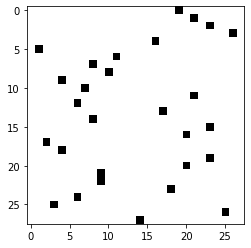

In [0]:
plt.imshow(arg_max_mask_encoder, cmap=plt.cm.binary)

In [0]:
decoder_img

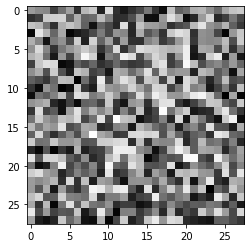

In [0]:
plt.imshow(np.reshape(first_layer_encoder_weights[:,2], newshape=(28, 28)), cmap=plt.cm.binary)

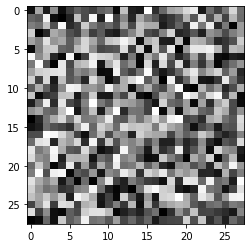

In [0]:
plt.imshow(np.reshape(last_layer_decoder_weights[2,:], newshape=(28, 28)), cmap=plt.cm.binary)

**Looks like the encoders are not learning anything, too much clutter and crappy output, cannot see any pattern. We see the same pattern in decoder too down below. Maybe we need to mask and get the top pixel in every row/column and visualize**

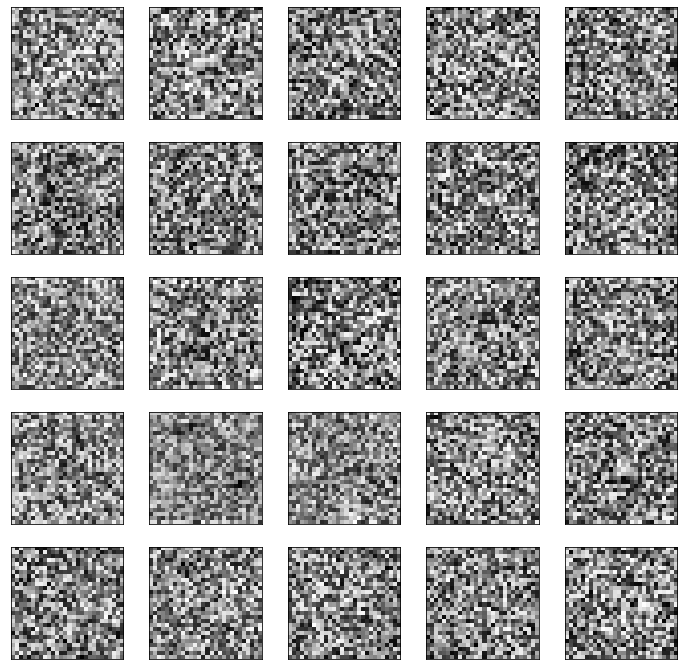

In [0]:
def output_model_encoders(weights, encoder_layer_num=0, filter_shape = (28, 28), images_to_be_compared=5):
  #Get the encoder output for each layer
  
  plt.figure(figsize=(12,12))

  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      filter_image = np.reshape(weights[encoder_layer_num][:,i], newshape=filter_shape)
      plt.imshow(filter_image, cmap=plt.cm.binary)      
      #plt.xlabel(class_names[test_images[i]])
  plt.show()

output_model_encoders(weights) 


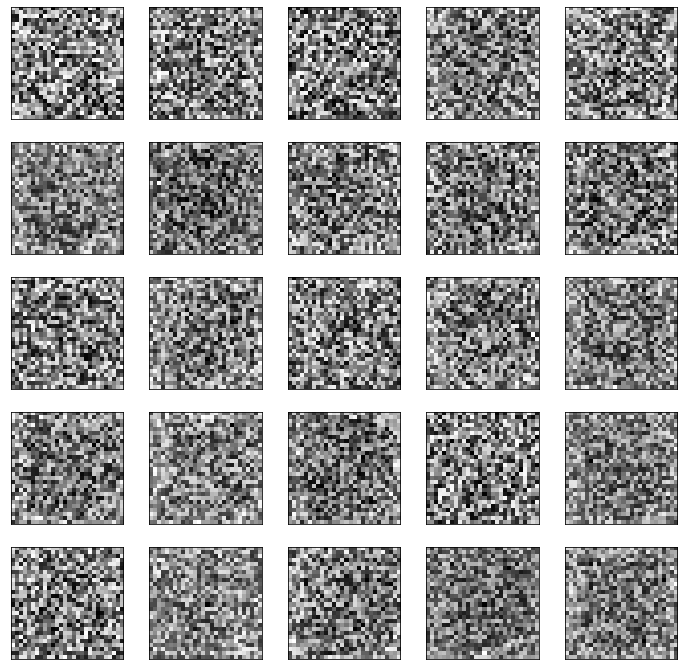

In [0]:
def output_model_decoders(weights, decoder_layer_num=14, filter_shape = (28, 28), images_to_be_compared=5):
  #Get the decoder output for each layer
  
  plt.figure(figsize=(12,12))

  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      filter_image = np.reshape(weights[decoder_layer_num][i,:], newshape=filter_shape)
      plt.imshow(filter_image, cmap=plt.cm.binary)      
      #plt.xlabel(class_names[test_images[i]])
  plt.show()

output_model_decoders(weights) 

**Get the best brightest pixel at every column, instead of a single pixel for entire matrix(winner takes all at column level).** 

**Encoder side**: Some pattern seems to emerge, especially ther 6th image looks a lot like number 8. But it seems like this is also not completely clear. Our encoder might have learnt nothing useful(You are free to imagine whatever shape you can think of from the filters!)

**Decoder side**: It seems there are some patterns in decoder , especially the last two images which seems like firing for numbers 3 and 8. Also the 8th image represents a straight line seen for numbers 1 and 7. This straight line pattern wasn't found for examined images in encoder side

In [0]:
def maskMatrix(inp_tensor):
  max_indices = tf.TensorArray(tf.dtypes.int64, 0, True)
  #values, indices = tf.math.top_k(inp_tensor, k=2, sorted=True)
  for x, i in enumerate(tf.math.argmax(inp_tensor, axis= 1).numpy()):
    max_indices = max_indices.write(x, [x,i])
  values = tf.ones(inp_tensor.shape[0], tf.dtypes.int64)
  return tf.sparse.to_dense(tf.sparse.SparseTensor(max_indices.stack(), values, inp_tensor.shape))

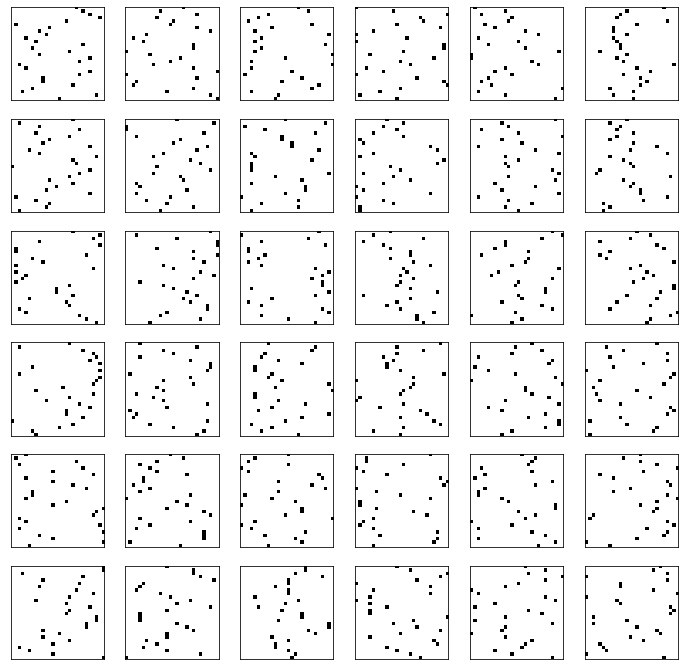

In [0]:
def output_model_encoders_with_argmax(weights, encoder_layer_num=0, filter_shape = (28, 28), images_to_be_compared=5):
  #Get the encoder output for each layer
  
  plt.figure(figsize=(12,12))

  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      
      numpy_filter_image = np.reshape(weights[encoder_layer_num][:,i], newshape=filter_shape)

      #Convert numpy to tensor for the argmax function, convert it back to numpy after recieving output from function
      encoder_img_tnsr = tf.convert_to_tensor(numpy_filter_image, dtype=tf.dtypes.float32)
      arg_max_mask_encoder = maskMatrix(encoder_img_tnsr).numpy()
      plt.imshow(arg_max_mask_encoder, cmap=plt.cm.binary)     


      #plt.xlabel(class_names[test_images[i]])
  plt.show()

output_model_encoders_with_argmax(weights) 

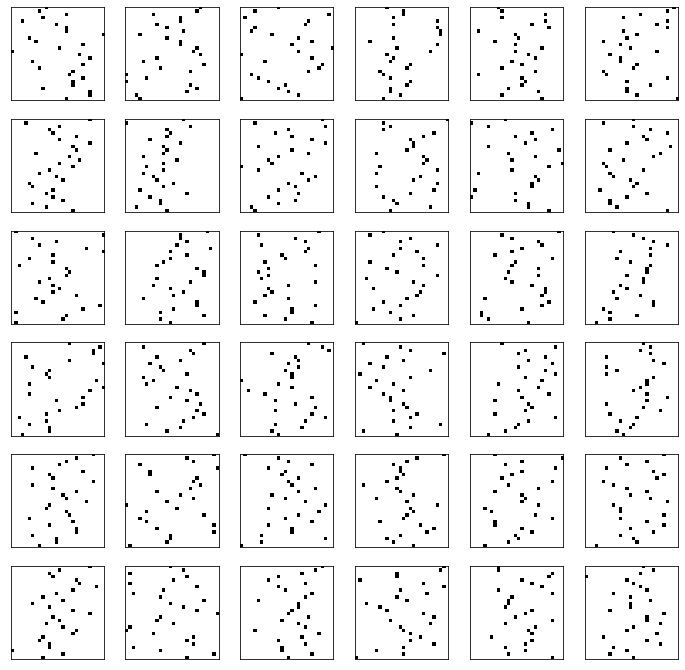

In [0]:
def output_model_decoders_with_argmax(weights, decoder_layer_num=14, filter_shape = (28, 28), images_to_be_compared=5):
  #Get the decoder output for each layer
  
  plt.figure(figsize=(12,12))

  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      
      numpy_filter_image = np.reshape(weights[decoder_layer_num][i,:], newshape=filter_shape)

      #Convert numpy to tensor for the argmax function, convert it back to numpy after recieving output from function
      decoder_img_tnsr = tf.convert_to_tensor(numpy_filter_image, dtype=tf.dtypes.float32)
      arg_max_mask_decoder = maskMatrix(decoder_img_tnsr).numpy()
      plt.imshow(arg_max_mask_decoder, cmap=plt.cm.binary)     


      #plt.xlabel(class_names[test_images[i]])
  plt.show()

output_model_decoders_with_argmax(weights) 

**Moving on to convolutional encoders**

We pick the conv model with FC layer in between, this removes any confusion regardig which dimension should we change as FC has only one dimension for all the records in the batch(1, 64). We cannot split the last part of decoder model, so create a new model and transfer the weights of the decoder part only.
Next time we can follow the coding guidelines mentioned in https://stackoverflow.com/questions/48603328/how-do-i-split-an-convolutional-autoencoder/48612403#48612403 to build a splittable model from scratch


**Steps:**

1) Split the Input-Encoder-Decoder-Output model to Input-Encoder and Decoder-Output model.

2) Get the output of encoder for test images and pick a single image of dimension (1,64) from 10000 encodings.

3) Change some values of the activations

4) Pipe this as input  for decoder-Output network model

5) Analyze the output.

Steps 3,4,5 can be doe in a loop or a separate function

In [0]:
for layer in conv_with_fc_model.layers: 
  print(layer.get_config())

conv_with_fc_weights = conv_with_fc_model.get_weights()
len(conv_with_fc_weights)

{'name': 'conv_enc_0', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'batch_normalization_45', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'ga

44

In [0]:
def evaluate_and_output_model(model, test_images, images_to_be_compared=5):
  class_names = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9']
  print(test_images.shape)
  #test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
  print(test_images.shape)
  #print('\n  Relu Test accuracy:', str(test_acc) + " test loss: " + str(test_loss) + "\n")
  model_output_images = model.predict(test_images)
  print(model_output_images.shape)
  plt.figure(figsize=(10,10))
  j = -1
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = j+1
      if(i%2 == 0):
        plt.imshow(test_images[i+10][:,:,0], cmap=plt.cm.binary)
      elif(j%2 == 1):
        
        plt.imshow(model_output_images[j-1+10][:,:,0], cmap=plt.cm.binary)
      
      #plt.xlabel(class_names[test_images[i]])
  plt.show()

In [0]:
conv_with_fc_model_output_images = conv_with_fc_model.predict(tf.expand_dims(test_images_raw.astype(np.float32)/255.0, -1))

In [0]:
conv_with_fc_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_45 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 7, 7, 128)       

In [0]:
layer_name = 'dense_14'
encoder_model = keras.Model(inputs=conv_with_fc_model.input, outputs=conv_with_fc_model.get_layer(layer_name).output)
intermediate_encoder_output = encoder_model(tf.expand_dims(test_images_raw.astype(np.float32)/255.0, -1))

In [0]:
intermediate_encoder_output.shape

TensorShape([10000, 64])

In [0]:
#  decoder_layer_dims=[32, 16, 1]
#decoder_model.add(layers.Dense(64,input_shape = (None,64)))
#model = keras.Sequential([keras.layers.Flatten(input_shape=input_shape)])

decoder_model = models.Sequential()
decoder_model.add(tf.keras.layers.InputLayer(input_shape=(64,)))
decoder_model.add(layers.Dense(252,activation=tf.nn.relu))
decoder_model.add(layers.Reshape((3, 3, 28), input_shape=(252,)))
decoder_model.add(layers.BatchNormalization()) 
decoder_model.add(layers.Conv2DTranspose(filters = 32, kernel_size=(3, 3),  strides=(2,2), padding = "valid", activation=tf.nn.relu))
decoder_model.add(layers.BatchNormalization()) 
decoder_model.add(layers.Conv2DTranspose(filters = 16, kernel_size=(3, 3),  strides=(2,2), padding = "same",  activation=tf.nn.relu))
decoder_model.add(layers.BatchNormalization())  
decoder_model.add(layers.Conv2DTranspose(filters = 1, kernel_size=(3, 3), strides=(2,2), padding = "same",  activation=tf.nn.sigmoid))

decoder_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 252)               16380     
_________________________________________________________________
reshape_3 (Reshape)          (None, 3, 3, 28)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 3, 28)          112       
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 32)          8096      
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 16)        4624      
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 16)       

In [0]:
#tf.shape(conv_with_fc_weights[33])
for i in range(len(conv_with_fc_weights)):
  print("index: " + str(i) + " | " + str(tf.shape(conv_with_fc_weights[i])))

index: 0 | tf.Tensor([ 3  3  1 32], shape=(4,), dtype=int32)
index: 1 | tf.Tensor([32], shape=(1,), dtype=int32)
index: 2 | tf.Tensor([32], shape=(1,), dtype=int32)
index: 3 | tf.Tensor([32], shape=(1,), dtype=int32)
index: 4 | tf.Tensor([32], shape=(1,), dtype=int32)
index: 5 | tf.Tensor([32], shape=(1,), dtype=int32)
index: 6 | tf.Tensor([ 3  3 32 64], shape=(4,), dtype=int32)
index: 7 | tf.Tensor([64], shape=(1,), dtype=int32)
index: 8 | tf.Tensor([64], shape=(1,), dtype=int32)
index: 9 | tf.Tensor([64], shape=(1,), dtype=int32)
index: 10 | tf.Tensor([64], shape=(1,), dtype=int32)
index: 11 | tf.Tensor([64], shape=(1,), dtype=int32)
index: 12 | tf.Tensor([  3   3  64 128], shape=(4,), dtype=int32)
index: 13 | tf.Tensor([128], shape=(1,), dtype=int32)
index: 14 | tf.Tensor([128], shape=(1,), dtype=int32)
index: 15 | tf.Tensor([128], shape=(1,), dtype=int32)
index: 16 | tf.Tensor([128], shape=(1,), dtype=int32)
index: 17 | tf.Tensor([128], shape=(1,), dtype=int32)
index: 18 | tf.Tenso

Set the weights of the decoder network to last half of the original network

In [0]:
decoder_model.set_weights(conv_with_fc_weights[24:])

In [0]:
"""
in_layer_name = 'dense_14'
out_layer_name = 'conv_dec_2'
decoder_model = keras.Model(inputs=conv_with_fc_model.get_layer(in_layer_name).output, outputs=conv_with_fc_model.get_layer(out_layer_name).output)
final_decoder_output = decoder_model(intermediate_encoder_output)
"""

In [0]:
def evaluate_decoder_output(model, test_images, images_to_be_compared=5):
  print(test_images.shape)
  #test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
  #print('\n  Relu Test accuracy:', str(test_acc) + " test loss: " + str(test_loss) + "\n")
  model_output_images = model.predict(test_images)
  print(model_output_images.shape)
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(model_output_images[i][:,:,0], cmap=plt.cm.binary)
  plt.show()

(10000, 64)
(10000, 28, 28, 1)


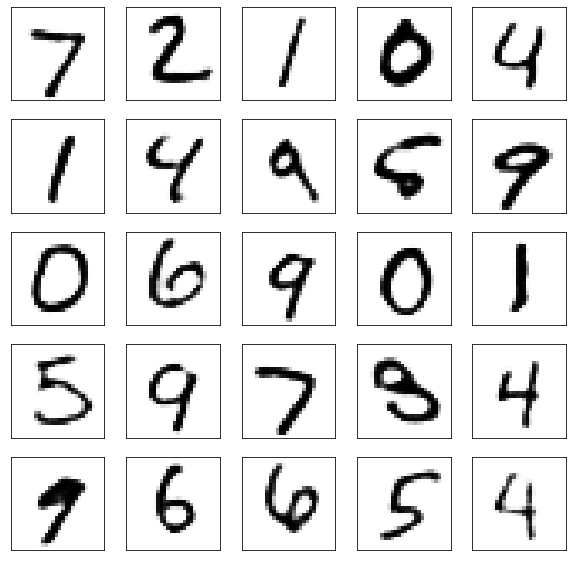

In [0]:
evaluate_decoder_output(decoder_model,intermediate_encoder_output)

In [0]:
intermediate_encoder_output[0,:]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([13.453639  , 31.630007  , 18.185455  , 35.50594   , -4.5379257 ,
       -5.4144473 , 26.704481  , -7.1359696 , 32.901005  , 12.701061  ,
       -7.1228943 ,  5.684326  , 32.59292   , 60.896988  ,  8.365037  ,
        6.3924403 , 13.184331  , -7.024774  , 17.711899  , -0.44040972,
       42.78759   , 14.10446   , 10.690807  , 45.10075   , 11.143951  ,
       15.829571  , 36.0637    ,  5.4546623 , 58.81245   , 36.271484  ,
       18.38586   , 37.012257  , 28.428572  , 15.633062  ,  6.103594  ,
       21.474867  , 41.364563  , -2.7767713 , -0.59911764,  0.79074156,
        5.509033  , 10.828833  , 38.360165  , 38.817566  , -0.9899268 ,
       32.919807  ,  4.8763657 , 14.283403  , 14.318804  , 54.393093  ,
       32.04976   , 30.06166   , 25.769444  , -1.8114014 , 21.5779    ,
       35.061848  , -5.9616585 , 27.752203  , 25.972221  , 54.787918  ,
       -0.6382202 , 22.784504  , 29.357204  , 20.013067  ], dtype=float32)>

**Just inverted all the encoding values by multiplying with -1. As ecpected we see that the pixels around the edges are getting activated and not the pixels in between as numbers are mostly present in middle of the picture**

In [0]:
changed_encoder_input = tf.expand_dims(tf.multiply(intermediate_encoder_output[0,:] , -1), 0)
changed_encoder_input.shape

TensorShape([1, 64])

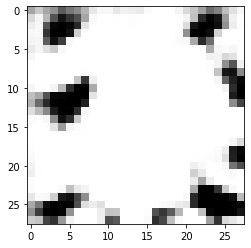

In [0]:
ic = decoder_model.predict(changed_encoder_input)
plt.figure(figsize=(4,4))
plt.imshow(ic[0][:,:,0], cmap=plt.cm.binary)
plt.show()

In [0]:
changed_encoder_input = tf.multiply(changed_encoder_input,-1)

changed_encoder_input

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[13.453639  , 31.630007  , 18.185455  , 35.50594   , -4.5379257 ,
        -5.4144473 , 26.704481  , -7.1359696 , 32.901005  , 12.701061  ,
        -7.1228943 ,  5.684326  , 32.59292   , 60.896988  ,  8.365037  ,
         6.3924403 , 13.184331  , -7.024774  , 17.711899  , -0.44040972,
        42.78759   , 14.10446   , 10.690807  , 45.10075   , 11.143951  ,
        15.829571  , 36.0637    ,  5.4546623 , 58.81245   , 36.271484  ,
        18.38586   , 37.012257  , 28.428572  , 15.633062  ,  6.103594  ,
        21.474867  , 41.364563  , -2.7767713 , -0.59911764,  0.79074156,
         5.509033  , 10.828833  , 38.360165  , 38.817566  , -0.9899268 ,
        32.919807  ,  4.8763657 , 14.283403  , 14.318804  , 54.393093  ,
        32.04976   , 30.06166   , 25.769444  , -1.8114014 , 21.5779    ,
        35.061848  , -5.9616585 , 27.752203  , 25.972221  , 54.787918  ,
        -0.6382202 , 22.784504  , 29.357204  , 20.013067  ]],
      dtype=f

In [0]:
lower_tensor = tf.greater(changed_encoder_input,y=40)
upper_tensor = tf.less(changed_encoder_input, y=100)
in_range = tf.logical_not(tf.logical_and(lower_tensor, upper_tensor))
in_range
new_encoder_state = tf.where(in_range, x=changed_encoder_input, y=0)
new_encoder_state

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[13.453639  , 31.630007  , 18.185455  , 35.50594   , -4.5379257 ,
        -5.4144473 , 26.704481  , -7.1359696 , 32.901005  , 12.701061  ,
        -7.1228943 ,  5.684326  , 32.59292   ,  0.        ,  8.365037  ,
         6.3924403 , 13.184331  , -7.024774  , 17.711899  , -0.44040972,
         0.        , 14.10446   , 10.690807  ,  0.        , 11.143951  ,
        15.829571  , 36.0637    ,  5.4546623 ,  0.        , 36.271484  ,
        18.38586   , 37.012257  , 28.428572  , 15.633062  ,  6.103594  ,
        21.474867  ,  0.        , -2.7767713 , -0.59911764,  0.79074156,
         5.509033  , 10.828833  , 38.360165  , 38.817566  , -0.9899268 ,
        32.919807  ,  4.8763657 , 14.283403  , 14.318804  ,  0.        ,
        32.04976   , 30.06166   , 25.769444  , -1.8114014 , 21.5779    ,
        35.061848  , -5.9616585 , 27.752203  , 25.972221  ,  0.        ,
        -0.6382202 , 22.784504  , 29.357204  , 20.013067  ]],
      dtype=f

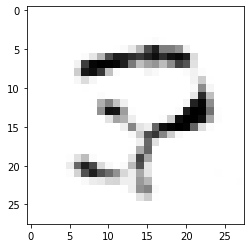

In [0]:
ic1 = decoder_model.predict(new_encoder_state)
plt.figure(figsize=(4,4))
plt.imshow(ic1[0][:,:,0], cmap=plt.cm.binary)
plt.show()

**inside range images:** Check out the stroke thickness changes of 7 which is particularly evident for images present at subplot 2,5,6,7. Especially image at 6 has some part cutoff. Hence encoding whoise value between 30-35 seems important 

**outside range images:** We again see that just with encoding values between 30-40, that is image at subplot position 3 seems to have figured out the straight line stroke which is necessary for numbers 9,1,7

(1, 64)
Upper limit and lower limit encoding state: 60 : 56
Upper limit and lower limit encoding state: 56 : 52
Upper limit and lower limit encoding state: 52 : 48
Upper limit and lower limit encoding state: 48 : 44
Upper limit and lower limit encoding state: 44 : 40
Upper limit and lower limit encoding state: 40 : 36
Upper limit and lower limit encoding state: 36 : 32
Upper limit and lower limit encoding state: 32 : 28
Upper limit and lower limit encoding state: 28 : 24
Upper limit and lower limit encoding state: 24 : 20
Upper limit and lower limit encoding state: 20 : 16
Upper limit and lower limit encoding state: 16 : 12
Upper limit and lower limit encoding state: 12 : 8
Upper limit and lower limit encoding state: 8 : 4
Upper limit and lower limit encoding state: 4 : 0
Upper limit and lower limit encoding state: 0 : -4
Upper limit and lower limit encoding state: -4 : -8
Upper limit and lower limit encoding state: -8 : -12
Upper limit and lower limit encoding state: -12 : -16
Upper l

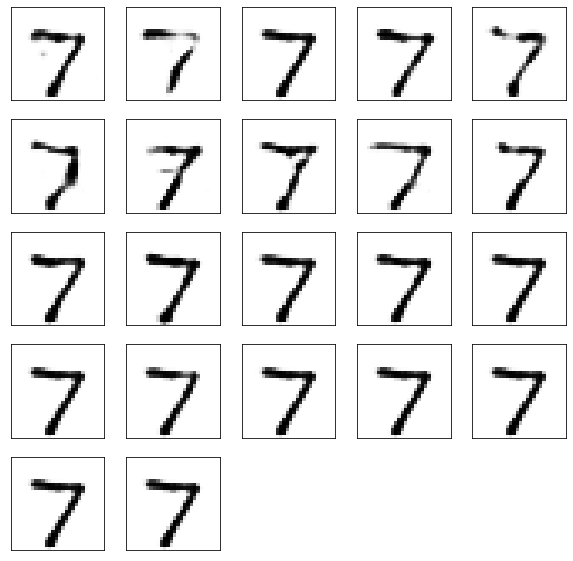

In [0]:
encoding = tf.expand_dims(intermediate_encoder_output[0,:] , 0)

def evaluate_decoder_output(decoder_model=decoder_model, encoding=encoding, manipulation_range=[-30,60], images_to_be_compared=5):
  print(encoding.shape)
  steps = round((-1 * manipulation_range[0] + manipulation_range[1])/25)
  num_itr = round((-1 * manipulation_range[0] + manipulation_range[1])/steps)

  upper_limit = manipulation_range[1]
  lower_limit = manipulation_range[1]-steps
  plt.figure(figsize=(10,10))

  for i in range(num_itr):
      
    print("Upper limit and lower limit encoding state: " + str(upper_limit) + " : " + str(lower_limit))
    lower_tensor = tf.greater(encoding,y=lower_limit)
    upper_tensor = tf.less(encoding, y=upper_limit)
    in_range = tf.logical_not(tf.logical_and(lower_tensor, upper_tensor))
    not_in_range = tf.logical_and(lower_tensor, upper_tensor)

    new_encoder_state_inside_range = tf.where(in_range, x=encoding, y=0)
    new_encoder_state_outside_range = tf.where(not_in_range, x=encoding, y=0)
    
    model_output_images_inside_range = decoder_model.predict(new_encoder_state_inside_range)
    model_output_images_outside_range = decoder_model.predict(new_encoder_state_outside_range)
  
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_output_images_inside_range[0][:,:,0], cmap=plt.cm.binary)
    
    upper_limit = lower_limit
    lower_limit = lower_limit - steps

  plt.show()

  return;

"""
    plt.subplot(5,5,i+2)
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_output_images_outside_range[0][:,:,0], cmap="Greys_r")
"""

  
evaluate_decoder_output()

(1, 64)
Upper limit and lower limit encoding state: 60 : 51
Upper limit and lower limit encoding state: 51 : 42
Upper limit and lower limit encoding state: 42 : 33
Upper limit and lower limit encoding state: 33 : 24
Upper limit and lower limit encoding state: 24 : 15
Upper limit and lower limit encoding state: 15 : 6
Upper limit and lower limit encoding state: 6 : -3
Upper limit and lower limit encoding state: -3 : -12
Upper limit and lower limit encoding state: -12 : -21
Upper limit and lower limit encoding state: -21 : -30


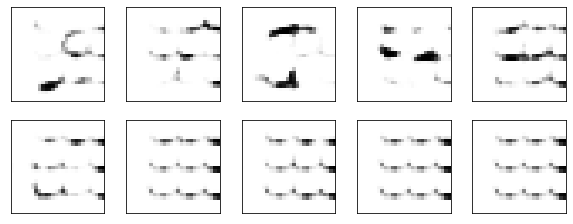

In [0]:
encoding = tf.expand_dims(intermediate_encoder_output[0,:] , 0)

def evaluate_decoder_output(decoder_model=decoder_model, encoding=encoding, manipulation_range=[-30,60], images_to_be_compared=5):
  print(encoding.shape)
  steps = round((-1 * manipulation_range[0] + manipulation_range[1])/10)
  num_itr = round((-1 * manipulation_range[0] + manipulation_range[1])/steps)

  upper_limit = manipulation_range[1]
  lower_limit = manipulation_range[1]-steps
  plt.figure(figsize=(10,10))

  for i in range(num_itr):
      
    print("Upper limit and lower limit encoding state: " + str(upper_limit) + " : " + str(lower_limit))
    lower_tensor = tf.greater(encoding,y=lower_limit)
    upper_tensor = tf.less(encoding, y=upper_limit)
    in_range = tf.logical_not(tf.logical_and(lower_tensor, upper_tensor))
    not_in_range = tf.logical_and(lower_tensor, upper_tensor)

    new_encoder_state_inside_range = tf.where(in_range, x=encoding, y=0)
    new_encoder_state_outside_range = tf.where(not_in_range, x=encoding, y=0)
    
    model_output_images_inside_range = decoder_model.predict(new_encoder_state_inside_range)
    model_output_images_outside_range = decoder_model.predict(new_encoder_state_outside_range)
  
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_output_images_outside_range[0][:,:,0], cmap=plt.cm.binary)
    
    upper_limit = lower_limit
    lower_limit = lower_limit - steps

  plt.show()

  return;

"""
    plt.subplot(5,5,i+2)
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_output_images_outside_range[0][:,:,0], cmap="Greys_r")
"""

  
evaluate_decoder_output()

# **Unsupervised Pretraining**

1) Train autoencoder – freeze encoder – train classifier on top (as described above).

2) Train autoencoder – train classifier on top of encoder. Do not freeze the encoder, i.e. the encoder is “fine-tuned” on the labeled subset of data as well.

3) Train a classifier directly on the labeled subset; no pretraining. For fairness, it should have the same architecture as the encoder + classifier above.

**Credits:**
Logistic regression using Keras - https://medium.com/hackernoon/logistic-regression-with-tensorflow-and-keras-83d2487aed89

**Summary:**

**Option 1:** Provided the worst accuracy where freezed encoder output was used to train a neural network classifier. Accuracy around 68% and loss did not drop well.

**Option 2:** When encoder was stacked on top of classifier and trained with it on dataset, we saw validation accuracy go up till 98-99% which was greater compared to simpler classifier. hence encoder was finetuned on the data. Also the loss decreased and saturated to much lower value than it did for freezed encoder Option 1.

**Option 3:** Simple neural network classifier gave 96% validation accuracy

**Error: **ResourceExhaustedError: OOM when allocating tensor with shape[60000,32,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

The dataset may be too huge to fit/predict. do batchwise prediction manually and concatenate the results

**Option 3:** **Training a Logistic regression classifier**

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [0]:
logistic_regression_model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [0]:
logistic_regression_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [13]:
logistic_regression_model.fit(train_images, train_labels, epochs=7, validation_data=(test_images, test_labels))

Epoch 1/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3829 - accuracy: 0.8886 - val_loss: 0.2128 - val_accuracy: 0.9384
Epoch 2/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1897 - accuracy: 0.9443 - val_loss: 0.1628 - val_accuracy: 0.9515
Epoch 3/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1505 - accuracy: 0.9556 - val_loss: 0.1464 - val_accuracy: 0.9561
Epoch 4/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1255 - accuracy: 0.9623 - val_loss: 0.1413 - val_accuracy: 0.9552
Epoch 5/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1097 - accuracy: 0.9670 - val_loss: 0.1225 - val_accuracy: 0.9629
Epoch 6/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0968 - accuracy: 0.9710 - val_loss: 0.1297 - val_accuracy: 0.9618
Epoch 7/7
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0868 - accuracy: 0.9731 - val_loss: 0.1326 - val_accuracy: 0.9626

In [16]:
logitstic_regresssion_model_output = logistic_regression_model(test_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



**Option 1: Stacking freezed encoder output as input to new logistic regression model. Checking the metrics**

In [0]:
stacked_logistic_regression_model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [0]:
stacked_logistic_regression_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [46]:
!unzip /content/conv_model_with_fc_noise.zip -d /content/conv_model_with_fc_noise
conv_with_fc_model_noise = tf.keras.models.load_model('/content/conv_model_with_fc_noise')

Archive:  /content/conv_model_with_fc_noise.zip
replace /content/conv_model_with_fc_noise/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/conv_model_with_fc_noise/variables/variables.index  
replace /content/conv_model_with_fc_noise/__MACOSX/variables/._variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/conv_model_with_fc_noise/__MACOSX/variables/._variables.index  
  inflating: /content/conv_model_with_fc_noise/variables/variables.data-00000-of-00002  
  inflating: /content/conv_model_with_fc_noise/__MACOSX/variables/._variables.data-00000-of-00002  
  inflating: /content/conv_model_with_fc_noise/variables/variables.data-00001-of-00002  
  inflating: /content/conv_model_with_fc_noise/__MACOSX/variables/._variables.data-00001-of-00002  
  inflating: /content/conv_model_with_fc_noise/__MACOSX/._variables  
  inflating: /content/conv_model_with_fc_noise/saved_model.pb  
  inflating: /content/conv_model_with_fc_noise/__M

In [47]:
for layer in conv_with_fc_model_noise.layers: 
  print(layer.get_config())

conv_with_fc_noise_weights = conv_with_fc_model_noise.get_weights()
len(conv_with_fc_noise_weights)

{'name': 'conv_enc_0', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gam

44

In [0]:
conv_with_fc_model_noise_output_images = conv_with_fc_model_noise.predict(tf.expand_dims(test_images.astype(np.float32), -1))

In [22]:
tf.expand_dims(test_images.astype(np.float32), -1).shape

TensorShape([10000, 28, 28, 1])

In [34]:
layer_name = 'dense_4'
encoder_model = keras.Model(inputs=conv_with_fc_model_noise.input, outputs=conv_with_fc_model_noise.get_layer(layer_name).output)
intermediate_encoder_test_output = encoder_model(tf.expand_dims(test_images.astype(np.float32), -1))
intermediate_encoder_test_output.shape

TensorShape([10000, 64])

In [35]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0   

In [0]:
all_train_images = tf.expand_dims(train_images.astype(np.float32), -1)
train_images_1 = all_train_images[0:10000,:,:,:]
train_images_2 = all_train_images[10000:20000,:,:,:]
train_images_3 = all_train_images[20000:30000,:,:,:]
train_images_4 = all_train_images[30000:40000,:,:,:]
train_images_5 = all_train_images[40000:50000,:,:,:]
train_images_6 = all_train_images[50000:60000,:,:,:]

In [0]:
intermediate_encoder_train_output_1 = encoder_model(train_images_1)
intermediate_encoder_train_output_2 = encoder_model(train_images_2)
intermediate_encoder_train_output_3 = encoder_model(train_images_3)
intermediate_encoder_train_output_4 = encoder_model(train_images_4)
intermediate_encoder_train_output_5 = encoder_model(train_images_5)
intermediate_encoder_train_output_6 = encoder_model(train_images_6)

In [0]:
intermediate_encoder_train_output = tf.concat(values=[intermediate_encoder_train_output_1, intermediate_encoder_train_output_2, 
                                                      intermediate_encoder_train_output_3, intermediate_encoder_train_output_4, intermediate_encoder_train_output_5,
                                                      intermediate_encoder_train_output_6], axis = 0)

In [51]:
#intermediate_encoder_train_output = encoder_model()
print(intermediate_encoder_test_output.shape)
print(intermediate_encoder_train_output.shape)

(10000, 64)
(60000, 64)


In [52]:
tf.expand_dims(train_images.astype(np.float32), -1).shape

TensorShape([60000, 28, 28, 1])

In [56]:
stacked_logistic_regression_model.fit(intermediate_encoder_train_output, train_labels, epochs=20, validation_data=(intermediate_encoder_test_output, test_labels))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4402 - accuracy: 0.4576 - val_loss: 1.3489 - val_accuracy: 0.5003
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4060 - accuracy: 0.4769 - val_loss: 1.3264 - val_accuracy: 0.5282
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3592 - accuracy: 0.5081 - val_loss: 1.2455 - val_accuracy: 0.5602
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3059 - accuracy: 0.5416 - val_loss: 1.2705 - val_accuracy: 0.5425
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2265 - accuracy: 0.5799 - val_loss: 1.3537 - val_accuracy: 0.5027
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1492 - accuracy: 0.6105 - val_loss: 1.0433 - val_accuracy: 0.6453
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1045 - accuracy: 0.6256 - val_loss: 1.1280 - val_accuracy:

In [0]:
test_output = stacked_logistic_regression_model.predict(intermediate_encoder_test_output)

In [59]:
tf.math.argmax(test_output[:], axis=0)

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([9060, 2706, 5761, 9006, 7886, 7622, 8499, 7098, 7735, 4505])>

In [60]:
test_output[0,:]

array([8.3514471e-03, 2.4995202e-04, 3.2485509e-03, 6.3309461e-02,
       2.6432124e-05, 5.7151191e-02, 2.4524304e-06, 8.5127425e-01,
       4.1699256e-03, 1.2216434e-02], dtype=float32)

In [0]:
def display_model_output_with_actual_test_labels(model_output, actual_labels):
  images to be compared = 10
  

array([[0.10646329, 0.2668148 , 0.0400741 , ..., 0.08671366, 0.05830615,
        0.07980853],
       [0.11828209, 0.25999004, 0.0400731 , ..., 0.08917951, 0.05847553,
        0.08011828],
       [0.09121314, 0.2740859 , 0.04089353, ..., 0.08289477, 0.05898764,
        0.07978667],
       ...,
       [0.0871958 , 0.26466927, 0.04268398, ..., 0.08071279, 0.05920096,
        0.0845837 ],
       [0.0939716 , 0.2625935 , 0.04204065, ..., 0.08204732, 0.05899849,
        0.0825301 ],
       [0.10860542, 0.24563655, 0.04175898, ..., 0.08154271, 0.05780326,
        0.08091093]], dtype=float32)

In [0]:
stacked_logistic_regression_model2 = tf.keras.models.Sequential([
encoder_model,
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
stacked_logistic_regression_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [70]:
stacked_logistic_regression_model2.fit(train_images, train_labels, epochs=7, validation_data=(test_images, test_labels))

Epoch 1/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5237 - accuracy: 0.8862 - val_loss: 0.0865 - val_accuracy: 0.9733
Epoch 2/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0655 - accuracy: 0.9804 - val_loss: 0.0794 - val_accuracy: 0.9782
Epoch 3/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0481 - accuracy: 0.9861 - val_loss: 0.0513 - val_accuracy: 0.9856
Epoch 4/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0384 - accuracy: 0.9887 - val_loss: 0.0482 - val_accuracy: 0.9856
Epoch 5/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0339 - accuracy: 0.9901 - val_loss: 0.0817 - val_accuracy: 0.9788
Epoch 6/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0277 - accuracy: 0.9918 - val_loss: 0.0410 - val_accuracy: 0.9885
Epoch 7/7
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0242 - accuracy: 0.9930 - val_loss: 0.0473 - val_accuracy: 0.9887

In [0]:
option_2_output = stacked_logistic_regression_model2.predict(test_images)

In [0]:
def compare_models(test_labels=test_labels,option_1_output = test_output, option_2_output=option_2_output, option_3_output = logistic_regression_model):

  option_1_preds = tf.argmax(option_1_output, axis=1,output_type=tf.int32)
  option_1_acc = tf.reduce_mean(tf.cast(tf.equal(option_1_preds, test_labels),tf.float32))
  print("Accuracy of Option 1 set: " + str(option_1_acc.numpy()))

  option_2_preds = tf.argmax(option_2_output, axis=1,output_type=tf.int32)
  option_2_acc = tf.reduce_mean(tf.cast(tf.equal(option_2_preds, test_labels),tf.float32))
  print("Accuracy of Option 2 set: " + str(option_2_acc.numpy()))
  
  option_3_preds = tf.argmax(option_3_output, axis=1,output_type=tf.int32)
  option_3_acc = tf.reduce_mean(tf.cast(tf.equal(option_3_preds, test_labels),tf.float32))
  print("Accuracy of Option 3 set: " + str(option_3_acc.numpy()))

  return ;

In [73]:
compare_models(test_labels, option_1_output = test_output, option_3_output = logitstic_regresssion_model_output)

Accuracy of Option 1 set: 0.6808
Accuracy of Option 2 set: 0.9887
Accuracy of Option 3 set: 0.9626


In [0]:
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = mnist.load_data()

train_data = tf.data.Dataset.from_tensor_slices(( train_images_raw.astype(np.float32)/255.0, train_images_raw.astype(np.float32)/255.0 ))

train_data = train_data.shuffle(buffer_size = train_images_raw.shape[0]).batch(32)

#test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0, test_labels_raw.astype(np.int32) ))
test_data = tf.data.Dataset.from_tensor_slices(( test_images_raw.astype(np.float32)/255.0,  test_images_raw.astype(np.float32)/255.0 ))
test_data = test_data.batch(32)

In [0]:

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 25
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [0]:
datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15, preprocessing_function=add_noise )


In [0]:
def create_conv_autoencoder_model(encoder_layer_dims=[32,64,128], compression_layer_dim=64, decoder_layer_dims=[32, 16, 1], input_shape=(28,28,1), ks=3,
                 compression_flag=True ,batch_norm_flag=True, dense_latent_rep_flag=False, upsampling_flag = False):
  model = models.Sequential()
  
  #Build encoder part, add batch norm after encoder if batch norm flag is set to true
  conv_enc_base_name = "conv_enc_"
  conv_cmprsn_base_name = "conv_compress_dims"
  conv_dec_base_name = "conv_dec_"
  for i in range (len(encoder_layer_dims)):
    #For first layer we need to specify shape
    if(i == 0):
      model.add(layers.Conv2D(filters = encoder_layer_dims[i], kernel_size=(ks, ks),  padding = "same", 
                              activation=tf.nn.relu, name = conv_enc_base_name + str(i), input_shape = input_shape))
      if(batch_norm_flag):
        model.add(layers.BatchNormalization()) 

      model.add(layers.MaxPool2D(pool_size=(2,2)))
    else:
      model.add(layers.Conv2D(filters = encoder_layer_dims[i], kernel_size=(ks, ks),  padding = "same", 
                              activation=tf.nn.relu, name = conv_enc_base_name + str(i)))
      
      if(batch_norm_flag):
        model.add(layers.BatchNormalization()) 

      model.add(layers.MaxPool2D(pool_size=(2,2)))
  
  print("Encoder has been built, checking for compression flag")

  if(compression_flag):
    model.add(layers.Conv2D(filters = compression_layer_dim, kernel_size=(1, 1),  padding = "same", activation = tf.nn.relu, name = conv_cmprsn_base_name))

  # With one-d dense representation is hardcoded for this one casem without this we can pick dynamically
  if(dense_latent_rep_flag):
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation=tf.nn.relu))
    model.add(layers.Dense(64,activation=tf.nn.leaky_relu))
    model.add(layers.Dense(252,activation=tf.nn.relu))
    model.add(layers.Reshape((3, 3, 28), input_shape=(252,)))

  print("FC layer added, printing model summary")

  #print(model.summary())
  #Build Decoder , add batch norm before adding conv transpose, Use sigmoid at final layer and relu for others
  if(upsampling_flag == False):
    for i in range (len(decoder_layer_dims)):
      if(i == 0):
        if(batch_norm_flag):
          model.add(layers.BatchNormalization()) 

        model.add(layers.Conv2DTranspose(filters = decoder_layer_dims[i], kernel_size=(ks, ks),  strides=(2,2), padding = "valid", 
                                  activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
        
      elif(i < len(decoder_layer_dims)-1 and i > 0):

        if(batch_norm_flag):
          model.add(layers.BatchNormalization()) 

        model.add(layers.Conv2DTranspose(filters = decoder_layer_dims[i], kernel_size=(ks, ks),  strides=(2,2), padding = "same", 
                                  activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
      else:
        if(batch_norm_flag):
          model.add(layers.BatchNormalization())  

        model.add(layers.Conv2DTranspose(filters = decoder_layer_dims[i], kernel_size=(ks, ks), strides=(2,2), padding = "same", 
                                  activation=tf.nn.sigmoid, name = conv_dec_base_name + str(i)))
        
  elif(upsampling_flag == True):
      print("Upscaling with convolution choosen")
      for i in range (len(decoder_layer_dims)):
        if(i == 0):
          model.add(layers.UpSampling2D(size=(3, 3)))
          if(batch_norm_flag):
            model.add(layers.BatchNormalization()) 

          model.add(layers.Conv2D(filters = decoder_layer_dims[i], kernel_size=(ks, ks), padding = "valid", activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
          model.add(layers.UpSampling2D())

        elif(i < len(decoder_layer_dims)-1 and i > 0):

          if(batch_norm_flag):
            model.add(layers.BatchNormalization()) 

          model.add(layers.Conv2D(filters = decoder_layer_dims[i], kernel_size=(ks, ks), padding = "same", activation=tf.nn.relu, name = conv_dec_base_name + str(i)))
          model.add(layers.UpSampling2D())
        else:
          if(batch_norm_flag):
            model.add(layers.BatchNormalization())  

          model.add(layers.Conv2D(filters = decoder_layer_dims[i], kernel_size=(ks, ks),  padding = "same", activation=tf.nn.sigmoid, name = conv_dec_base_name + str(i)))
        
  print("Model has been built, printing summary")
  
  print(model.summary())
  return model;

In [0]:
conv_model_with_fc = create_conv_autoencoder_model(dense_latent_rep_flag=True)
conv_model_with_fc.summary()

Encoder has been built, checking for compression flag
FC layer added, printing model summary
Model has been built, printing summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_enc_0 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)         

In [0]:
conv_model_with_fc.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["accuracy"])

In [0]:
x = tf.expand_dims(train_images_raw.astype(np.float32)/255.0 , -1)
y = tf.expand_dims(train_images_raw.astype(np.float32)/255.0, -1)
print(x.shape)
print(x.dtype)

(60000, 28, 28, 1)
<dtype: 'float32'>


In [0]:
#conv_model_with_fc.fit(x=x, y=y, epochs=7)

In [0]:
test_data = tf.expand_dims(test_images_raw.astype(np.float32)/255.0 , -1)
#steps_per_epoch =  x.shape[0]/128,

In [0]:
conv_model_with_fc.fit(datagen.flow(x, y, batch_size=128,shuffle=True), batch_size=128,  epochs = 10 ,validation_data =(test_data, test_data))

Epoch 1/10
469/469 [==============================] - 35s 75ms/step - loss: 0.1471 - accuracy: 0.7639 - val_loss: 0.1431 - val_accuracy: 0.7629
Epoch 2/10
469/469 [==============================] - 35s 75ms/step - loss: 0.1309 - accuracy: 0.7934 - val_loss: 0.1276 - val_accuracy: 0.8070
Epoch 3/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1261 - accuracy: 0.7997 - val_loss: 0.1325 - val_accuracy: 0.7802
Epoch 4/10
469/469 [==============================] - 34s 73ms/step - loss: 0.1253 - accuracy: 0.8004 - val_loss: 0.1247 - val_accuracy: 0.8045
Epoch 5/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1248 - accuracy: 0.8002 - val_loss: 0.1194 - val_accuracy: 0.8013
Epoch 6/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1246 - accuracy: 0.8003 - val_loss: 0.1175 - val_accuracy: 0.7950
Epoch 7/10
469/469 [==============================] - 35s 75ms/step - loss: 0.1244 - accuracy: 0.8003 - val_loss: 0.1159 - val_accuracy:

In [0]:
final_output = conv_model_with_fc.predict(test_data)

In [0]:
final_output.shape

(10000, 28, 28, 1)

In [0]:
conv_model_with_fc.save("/content/conv_model_with_fc_noise")
!zip -r /content/conv_model_with_fc_noise.zip /content/conv_model_with_fc_noise

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/conv_model_with_fc_noise/assets
  adding: content/conv_model_with_fc_noise/ (stored 0%)
  adding: content/conv_model_with_fc_noise/saved_model.pb (deflated 91%)
  adding: content/conv_model_with_fc_noise/assets/ (stored 0%)
  adding: content/conv_model_with_fc_noise/variables/ (stored 0%)
  adding: content/conv_model_with_fc_noise/variables/variables.index (deflated 74%)
  adding: content/conv_model_with_fc_noise/variables/variables.data-00000-of-00002 (deflated 83%)
  adding: content/conv_model_with_fc_noise/variables/variables.data-00001-of-00002 (deflated 14%)


In [0]:
#model_config1.fit(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = 3*x_train.shape[0]/batch_size, 
#epochs = 10 ,validation_data =(x_test, y_test))

In [0]:
print(train_images_raw.shape)
layer_name = 'dense_4'
encoder_model_fc_noise = keras.Model(inputs=conv_model_with_fc.input, outputs=conv_model_with_fc.get_layer(layer_name).output)
#intermediate_encoder_fc_noise_output = encoder_model_fc_noise(tf.expand_dims(train_images_raw.astype(np.float32)/255.0, -1))
intermediate_encoder_fc_noise_output = encoder_model_fc_noise(train_images_raw.astype(np.float32))

(60000, 28, 28)


ResourceExhaustedError: ignored